In [ ]:
%%capture
!pip install pyspark
%load_ext rpy2.ipython

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *

import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MinMaxScaler

import time
import random

spark = SparkSession.builder.config('spark.cores.max', "16") \
                            .config("spark.executor.memory", "70g") \
                            .config("spark.driver.memory", "50g") \
                            .config("spark.memory.offHeap.enabled",True) \
                            .config("spark.memory.offHeap.size","16g") \
                            .getOrCreate()
spark.version

In [ ]:
def preprocess(df):
  df_p = df
  #change collumns name
  c = df_p.columns
  c_new = ['Document number','Document type (code)','Document type','Document version number','Document sale date','Document version time',
        'Sales type ID','Sales layer (code)','Sales Type','Consignee ID','Consignee nationality (code)','Consignee nationality','Receiving station',
        'Municipality of landing (code)','Municipality of landing','County of landing (code)','County of landing','Landing nation (code)',
        'Landing nation','Production facility','Production municipality (code)','Production municipality','Receiving vessel reg.mark',
        'Receiving vessel rkal','Receiving vessel type (code)','Receiving vessel type','Receiving vessel location (code)','Receiving vessel nation',
        'Fisherman ID','Fisherman municipality (code)','Fisherman municipality','Fisherman nationality (code)','Fisher nationality','Vessel ID',
        'Registration mark (note)','Radio call sign (note)','Vessel name','Vessel type (code)','Vessel type','Quota vessel registration mark',
        'Crew','Vessel municipality (code)','Vessel municipality','Vessel county (code)','Vessel county','Vessel nationality (code)',
        'Vessel nationality','Vessel nationality group','Maximum length','Length group (code)','Length group','Gross tonnage 1969',
        'Gross tonnage other','Year of construction','Year of conversion','Engine power','Year of engine construction','Year of catch',
        'Last catch date','Quota type (code)','Quota type','Gear (code)','Gear','Gear - group (code)','Gear - group','Gear - main group (code)',
        'Gear - main group','Catch field (code)','Coastal/sea (code)','Main area (code)','Main area','Lon (main area)','Lat (main area)',
        'Location (code)','Lon (location)','Lat (location)','Zone (code)','Zone','Area grouping (code)','Area grouping','Main area FAO (code)',
        'Main FAO area','North/South of 62 degrees North','Catch logbook (number)','Catch logbook (trip number)','Date of landing','Landing time',
        'Landing month (code)','Landing month','Landing date time','Partial landing (signal)','Next receiving station','Previous receiving station',
        'Line number','Species - FDIR (code)','Species - FDIR','Species (code)','Species','Species - group (code)','Species - group',
        'Species - main group (code)','Species - main group','Species FAO (code)','Species FAO','Product condition (code)','Product condition',
        'Mode of preservation (code)','Mode of preservation','Mode of landing (code)','Landing Mode','Quality (code)','Quality','Size grouping (code)',
        'Use (code)','Use','Use main group (code)','Application main group','Number of pieces','Gross weight','Product weight',
        'Product weight over quota','Round weight over quota','Round weight','Unit price for buyer','Amount for buyer','Unit price for fisherman',
        'Amount for fisherman','Amount of aid','Licence fee','Withdrawn catch value','Back payment','Catch value','Update time']

  #c_new = [j + '('+ k + ')' for j,k in zip(c,c_new)]
  c_new = [i.replace(' - ','_').replace(' ','_').replace('(','').replace(')','') for i in c_new]
  for i in range(len(c)):
    df_p = df_p.withColumnRenamed(c[i],c_new[i])

  #deal with missing value
  df_p = df_p.withColumn("Gross_weight",f.coalesce(df_p.Gross_weight,df_p.Product_weight))
  df_p = df_p.withColumn("Gross_tonnage_1969",f.coalesce(df_p.Gross_tonnage_1969,df_p.Gross_tonnage_other))
  df_p = df_p.filter(df_p.Location_code != 0)

  #change datatype
  df_p = df_p.withColumn('Lon_main_area', f.regexp_replace('Lon_main_area', ',', '.'))\
              .withColumn('Lat_main_area', f.regexp_replace('Lat_main_area', ',', '.'))\
              .withColumn('Lon_location', f.regexp_replace('Lon_location', ',', '.'))\
              .withColumn('Lat_location', f.regexp_replace('Lat_location', ',', '.'))\
              .withColumn('Gross_weight', f.regexp_replace('Gross_weight', ',', '.'))\
              .withColumn('Product_weight', f.regexp_replace('Product_weight', ',', '.'))\
              .withColumn('Round_weight', f.regexp_replace('Round_weight', ',', '.'))\
              .withColumn('Catch_value', f.regexp_replace('Catch_value', ',', '.'))\
              .withColumn('Maximum_length', f.regexp_replace('Maximum_length', ',', '.'))

  df_p = df_p.withColumn("Lon_main_area",f.col("Lon_main_area").cast(FloatType()))\
          .withColumn("Lat_main_area",f.col("Lat_main_area").cast(FloatType()))\
          .withColumn("Lon_location",f.col("Lon_location").cast(FloatType()))\
          .withColumn("Lat_location",f.col("Lat_location").cast(FloatType()))\
          .withColumn("Gross_weight",f.col("Gross_weight").cast(FloatType()))\
          .withColumn("Product_weight",f.col("Product_weight").cast(FloatType()))\
          .withColumn("Round_weight",f.col("Round_weight").cast(FloatType()))\
          .withColumn("Catch_value",f.col("Catch_value").cast(FloatType()))\
          .withColumn("Main_area_code",f.col("Main_area_code").cast(IntegerType()))\
          .withColumn("Location_code",f.col("Location_code").cast(IntegerType()))\
          .withColumn("Species_FDIR_code",f.col("Species_FDIR_code").cast(IntegerType()))\
          .withColumn("Year_of_catch",f.col("Year_of_catch").cast(IntegerType()))\
          .withColumn("Last_catch_date",f.to_date(f.col("Last_catch_date"),"dd.MM.yyyy"))\
          .withColumn("Maximum_length",f.col("Maximum_length").cast(FloatType()))\
          .withColumn("Gross_tonnage_1969",f.col("Gross_tonnage_1969").cast(IntegerType()))\
          .withColumn("Engine_power",f.col("Engine_power").cast(IntegerType()))

          #.orderBy(f.col('Last_capture_date'),f.col('Main_area_code'),f.col('Location_code'))

  #df_p = df_p.select('Last_capture_date','Location_code','Lat_location','Lon_location','Species_FDIR_code','Gross_weight','Gear_code')
  #df_p = df_p.groupby('Species_FDIR_code','Location_code').agg(f.mean('Gross_weight').alias('Gross_weight'))
  return df_p

In [ ]:
import zipfile
from urllib.request import urlopen
import requests
from os.path import exists

for i in tqdm.tqdm_notebook(range(2000,2024)):
  if(not exists('/content/fangstdata_{}.csv'.format(i))):

    if(i==2022):
      r = requests.get("https://register.fiskeridir.no/uttrekk/fangstdata_2022.csv.zip",allow_redirects=True)
      open('fangstdata_2022.csv.zip', 'wb').write(r.content)
      p = "/content/fangstdata_2022.csv.zip"

    elif(i==2023):
      r = requests.get("https://register.fiskeridir.no/uttrekk/fangstdata_2023.csv.zip",allow_redirects=True)
      open('fangstdata_2023.csv.zip', 'wb').write(r.content)
      p = "/content/fangstdata_2023.csv.zip"

    else:
      p = f"/content/drive/MyDrive/#2022-2023 HK2/BA/IS403.N21. Phân tích dữ liệu kinh doanh/Project/Sustainable Fishing Datasets/Catch Notes Datasets/fangstdata_{i}.csv.zip"

    with zipfile.ZipFile(p, 'r') as zip_ref:
      zip_ref.extractall('/content/')

  df_tmp = spark.read.options(header=True,delimiter=';').csv('/content/fangstdata_{}.csv'.format(i))
  df = df_tmp if(i==2000) else df.union(df_tmp)

<ipython-input-3-96976460e527>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(2000,2024)):


  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
dfp = preprocess(df)

In [ ]:
top10_fish = dfp.select('Species_FDIR').groupBy('Species_FDIR').count().sort('count',ascending=False).select('Species_FDIR').take(10)
top10_fish = np.array(top10_fish).reshape(-1)
#top10_fish = np.array(a.select('Species_FDIR').collect()).reshape(-1)

In [ ]:
#top3_fish
top3_fish = ['Nordøstarktisk torsk','Nordøstarktisk hyse','Kveite']

In [ ]:
a = dfp.filter(f.col('Species_FDIR')==top3_fish[2]).select('Last_catch_date','Gross_weight', 'Product_weight','Round_weight')

a = a.groupBy('Last_catch_date').agg(f.sum("Gross_weight"),
                                      f.sum('Product_weight'),
                                      f.sum('Round_weight')).sort('Last_catch_date',ascending=True)
a = a.collect()

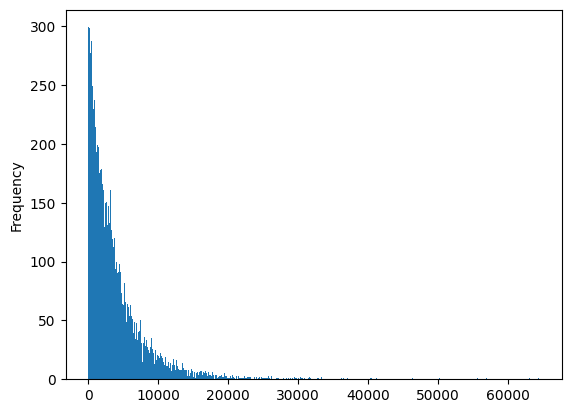

In [ ]:
species1 = pd.DataFrame(a)
species1.columns = ['Last_catch_date','Gross_weight', 'Product_weight','Round_weight']
species1 = species1[['Last_catch_date','Round_weight','Gross_weight','Product_weight']]
#species1.to_csv('NortheastArcticCod.csv',index=False)
#species1.to_csv('NortheastArcticHaddock.csv',index=False)
species1.to_csv('AtlanticHalibut.csv',index=False)


species1['Product_weight'].plot(kind='hist',bins=500)
plt.show()
# species1.iloc[-365*10:,2].plot()
# plt.show()